# Lesson 05: 
### Dylan Temples 
July 9, 2020

The goal of this lesson is to demonstrate a "general" data analysis. In this lesson, I generate some data using unknown parameters. This data is what we will analyze and try to learn something about.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(1362456)
g1_p = np.random.rand(3) * 10.
g2_p = np.random.rand(3) * 10.
u1_p = np.random.rand(1) * 10.
e1_p = np.random.rand(2) * 10.
norm = g1_p[0] + g2_p[0] + u1_p[0] + e1_p[0]
npts = 1000000
ndis = np.floor(np.array([g1_p[0],g2_p[0],u1_p[0],e1_p[0]])*npts/norm).astype(int)
ndis[0] = int(npts - np.sum(ndis[1:]))
data = np.array([])
g1   = np.random.normal(loc=g1_p[1],scale=g1_p[2],size=ndis[0])
data = np.append(data,g1)
g2   = np.random.normal(loc=g2_p[1],scale=g2_p[2],size=ndis[1])
data = np.append(data,g2)
e1   = np.random.exponential(scale=e1_p[1],size=ndis[3])
data = np.append(data,e1)
u1   = np.random.uniform(low=np.min([np.min(g1),np.min(g2),np.min(e1)]),high=np.max([np.max(g1),np.max(g2),np.max(e1)]),size=ndis[2])
data = np.append(data,u1)

np.savetxt("spectrum.dat", data, delimiter=',')

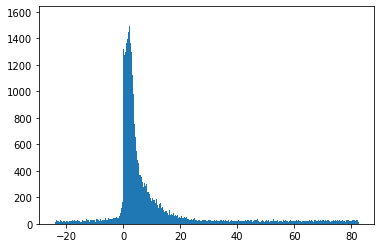

In [3]:
## Read in our data and plot it
data = np.loadtxt("spectrum.dat", delimiter=',')
N_bins = 10000
hist, bins, patches = plt.hist(data, bins=N_bins)

So there are a a few features in this spectrum, from which we will want to extract parameters that inform us about the distribution. It doesn't matter what this data is from, but we want to form a model for the observed data.

Clearly, there is some flat contribution over the whole range of our data, which we will refer to as background. Let's try to characterize the background. First, we'll give our x-axis units of recoil energy in keV (relative to some reference energy, which allows for negative values). Then we should look at the background distribution away from the peak.

Text(0, 0.5, 'Counts Per 100 eV')

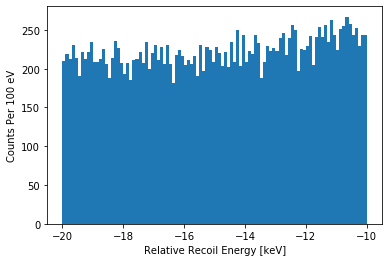

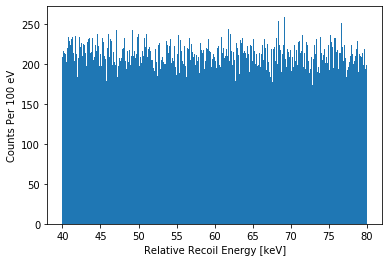

In [4]:
roi1_lims = np.array([-20,-10])
roi2_lims = np.array([ 40, 80])
bin_step  = 0.1

roi1_bins = np.arange(start=roi1_lims[0], stop=roi1_lims[1]+bin_step, step=bin_step)
roi2_bins = np.arange(start=roi2_lims[0], stop=roi2_lims[1]+bin_step, step=bin_step)

plt.figure()
n1, bins1, patches = plt.hist(data, bins=roi1_bins)
plt.xlabel("Relative Recoil Energy [keV]")
plt.ylabel("Counts Per 100 eV")

plt.figure()
n2, bins2, patches = plt.hist(data, bins=roi2_bins)
plt.xlabel("Relative Recoil Energy [keV]")
plt.ylabel("Counts Per 100 eV")

So the higher energy region looks flat by eye while the lower energy reason looks like it has a rising spectrum at lower energy. Let's test these hypotheses, starting with the high energy region.

Average counts per 100 eV: 211.755
Average deviation:  4.547473508864641e-15


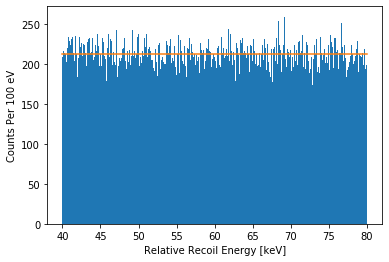

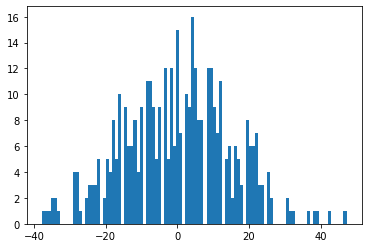

In [5]:
roi2_idx = (data>=roi2_lims[0]) * (data<=roi2_lims[1])
roi2_data = data[roi2_idx]

plt.figure()
n2, bins2, patches = plt.hist(roi2_data, bins=roi2_bins)
plt.xlabel("Relative Recoil Energy [keV]")
plt.ylabel("Counts Per 100 eV")

avg_cts_per_bin = np.mean(n2)
print("Average counts per 100 eV:",avg_cts_per_bin)

plt.plot(roi2_lims , avg_cts_per_bin*np.ones(2))

delta = n2-avg_cts_per_bin
print("Average deviation: ", np.mean(delta))
plt.figure()
n, bins, patches = plt.hist(delta, bins=100)

So in the high energy region, the data is consistent with a uniform distribution, with a specified rate in counts per bin (100 eV). Let's test this hypothesis against the low energy region.

In [7]:
HIGH_E_BIN_RATE = avg_cts_per_bin

Average deviation:  10.925000000000004


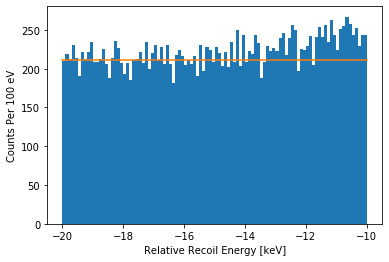

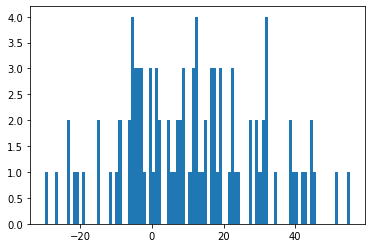

In [8]:
roi1_idx = (data>=roi1_lims[0]) * (data<=roi1_lims[1])
roi1_data = data[roi1_idx]

plt.figure()
n1, bins1, patches = plt.hist(roi1_data, bins=roi1_bins)
plt.plot(roi1_lims , HIGH_E_BIN_RATE*np.ones(2))
plt.xlabel("Relative Recoil Energy [keV]")
plt.ylabel("Counts Per 100 eV")

delta = n1-HIGH_E_BIN_RATE
print("Average deviation: ", np.mean(delta))
plt.figure()
n, bins, patches = plt.hist(delta, bins=100)

So, by eye, we can tell that the orange line does not capture the data above about -14 keV. There is definitely an excess toward the high energy end. This is reflected in the mean residual, which is ~11, compared to $10^{-15}$ in the high energy region. Similarly, the "residual" distribution is not normal about 0. Let's restrict the ROI 1 range to -14 keV and try this again.

Average deviation:  2.7950000000000044


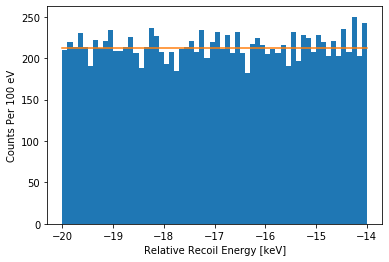

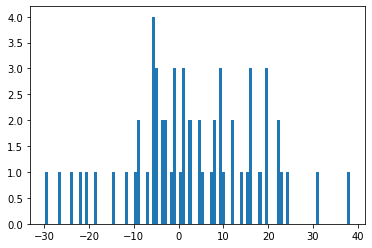

In [9]:
roi1_lims = np.array([-20,-14])
roi1_bins = np.arange(start=roi1_lims[0], stop=roi1_lims[1]+bin_step, step=bin_step)

roi1_idx = (data>=roi1_lims[0]) * (data<=roi1_lims[1])
roi1_data = data[roi1_idx]

plt.figure()
n1, bins1, patches = plt.hist(roi1_data, bins=roi1_bins)
plt.plot(roi1_lims , HIGH_E_BIN_RATE*np.ones(2))
plt.xlabel("Relative Recoil Energy [keV]")
plt.ylabel("Counts Per 100 eV")

delta = n1-HIGH_E_BIN_RATE
print("Average deviation: ", np.mean(delta))
plt.figure()
n, bins, patches = plt.hist(delta, bins=100)

We're doing better, but it's still not quite what we expect. Let's conclude that the background rate is accurately captured by the high energy region. With this we can start to build the PDF that describes our data. 

In [10]:
## Return this in units of counts per keV
def PDF_Background(energy):
    scale = HIGH_E_BIN_RATE / bin_step
    return scale * np.ones(len(energy))

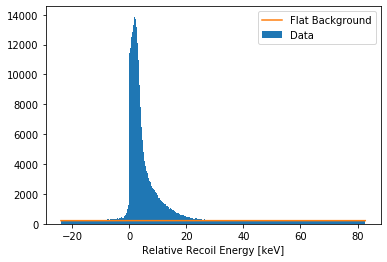

In [11]:
x_values = np.array([ np.min(data) , np.max(data)])
all_bins = np.arange(start=x_values[0],stop=x_values[1],step=bin_step)
pdf_bkgd = PDF_Background(all_bins)

plt.figure()
hist, bins, patches = plt.hist(data, bins=all_bins, label="Data")
plt.plot(all_bins, pdf_bkgd*bin_step, label="Flat Background")
plt.xlabel("Relative Recoil Energy [keV]")
plt.legend(loc='upper right')

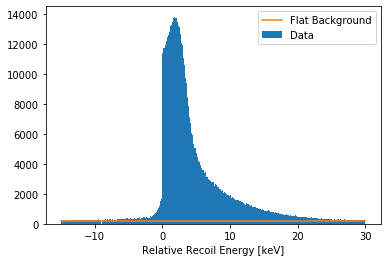

In [12]:
## Now look in signal ROI
roi_lims = np.array([-15,30])
roi_bins = np.arange(start=roi_lims[0], stop=roi_lims[1]+bin_step, step=bin_step)
roi_idx  = (data>=roi_lims[0]) * (data<=roi_lims[1])
roi_data = data[roi_idx]

plt.figure()
hist, bins, patches = plt.hist(roi_data, bins=roi_bins, label="Data")
plt.plot(roi_bins, PDF_Background(roi_bins)*bin_step, label="Flat Background")
plt.xlabel("Relative Recoil Energy [keV]")
plt.legend(loc='upper right')

Now we have to make some assumptions about what our data *should* look like. My eye is drawn to the hard cutoff at 0, which tells me there is something in our data making a contribution only at positive relative recoil energies (larger energies than some reference value). Given this hard cutoff and the long tail, I think exponential. But there's also a peak at an energy greater than 0. Let's zoom into this region and fit it to the sum of an exponential and a gaussian. We need to remember to include our background though.

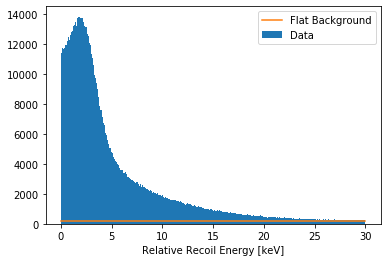

In [13]:
def exponential(E_keV, amp, scale):
    answer = amp*np.exp(-E_keV/scale)
    idx = (E_keV < 0)
    answer[idx] = 0
    return answer

def gauss(E_keV, amp, mu, sig):
    z = (E_keV-mu)/sig
    return amp*np.exp(-0.5*z*z)

def fit_shape(E_keV, exp_amp, exp_scale, g_amp, g_mu, g_sig):
    bkgd = PDF_Background(E_keV)
    exp  = exponential(E_keV, exp_amp, exp_scale)
    gaus = gauss(E_keV, g_amp, g_mu, g_sig)
    return (bkgd*bin_step) + exp + gaus

exp_p0  = np.array([12.0e3 , 30.0])
gaus_p0 = np.array([14.0e3 , 5.0 , 5.0])
init_guess = np.append(exp_p0,gaus_p0)

roi_lims = np.array([0.0,30.0])
roi_bins = np.arange(start=roi_lims[0], stop=roi_lims[1]+bin_step, step=bin_step)
roi_idx  = (data>=roi_lims[0]) * (data<=roi_lims[1])
roi_data = data[roi_idx]

plt.figure()
hist, bins, patches = plt.hist(roi_data, bins=roi_bins, label="Data")
plt.plot(roi_bins, PDF_Background(roi_bins)*bin_step, label="Flat Background")
plt.xlabel("Relative Recoil Energy [keV]")
plt.legend(loc='upper right')

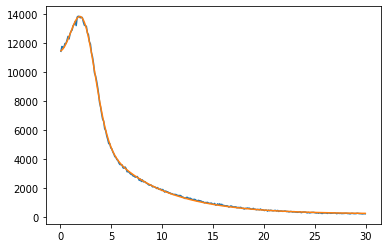

In [14]:
from scipy.optimize import curve_fit

bin_entries = hist
bin_centers = 0.5*(bins[1:]+bins[:-1])

plt.figure()
plt.plot(bin_centers, bin_entries, label="Data")

popt, pcov = curve_fit(fit_shape, bin_centers, bin_entries, p0=init_guess)

fit_vals = fit_shape(bin_centers, popt[0], popt[1], popt[2], popt[3], popt[4])
plt.plot(bin_centers, fit_vals, label="Fit")

Okay, we're close to getting it. Let's look at the residual of our model and all the data.

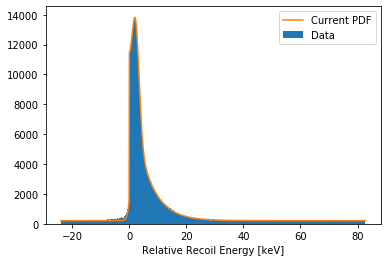

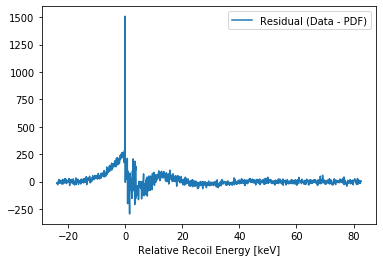

In [15]:
x_values = np.array([ np.min(data) , np.max(data)])
all_bins = np.arange(start=x_values[0],stop=x_values[1],step=bin_step)

current_pdf = fit_shape(all_bins, popt[0], popt[1], popt[2], popt[3], popt[4])

plt.figure()
hist, bins, patches = plt.hist(data, bins=all_bins, label="Data")
plt.plot(all_bins, current_pdf, label="Current PDF")
plt.xlabel("Relative Recoil Energy [keV]")
plt.legend(loc='upper right')

bin_entries = hist
bin_centers = 0.5*(bins[1:]+bins[:-1])
current_pdf = fit_shape(bin_centers, popt[0], popt[1], popt[2], popt[3], popt[4])
residual = bin_entries-current_pdf

plt.figure()
plt.plot(bin_centers, residual, label="Residual (Data - PDF)")
plt.xlabel("Relative Recoil Energy [keV]")
plt.legend(loc='upper right')

So the PDF is underestimating the distribution below 0 keV and 10--25 keV. Let's add in another Gaussian that is much lower in amplitude and much broader.

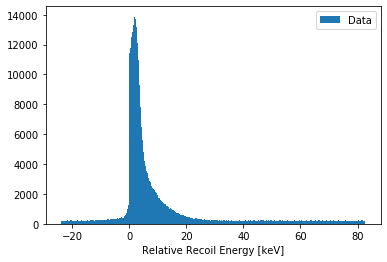

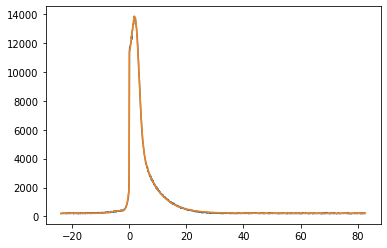

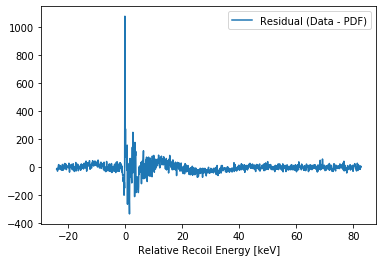

In [16]:
def fit_shape(E_keV, exp_amp, exp_scale, g1_amp, g1_mu, g1_sig, g2_amp, g2_mu, g2_sig):
    bkgd  = PDF_Background(E_keV)
    exp   = exponential(E_keV, exp_amp, exp_scale)
    gaus1 = gauss(E_keV, g1_amp, g1_mu, g1_sig)
    gaus2 = gauss(E_keV, g2_amp, g2_mu, g2_sig)
    return (bkgd*bin_step) + exp + gaus1 + gaus2

exp_p0   = np.array([12.0e3 , 30.0])
gaus1_p0 = np.array([14.0e3 ,  5.0 , 5.0])
gaus2_p0 = np.array([100.0  ,  1.0 , 50.0])
init_guess = np.append(np.append(exp_p0,gaus1_p0),gaus2_p0)

x_values = np.array([ np.min(data) , np.max(data)])
all_bins = np.arange(start=x_values[0],stop=x_values[1],step=bin_step)

plt.figure()
hist, bins, patches = plt.hist(data, bins=all_bins, label="Data")
plt.xlabel("Relative Recoil Energy [keV]")
plt.legend(loc='upper right')

bin_entries = hist
bin_centers = 0.5*(bins[1:]+bins[:-1])

plt.figure()
plt.plot(bin_centers, bin_entries, label="Data")

popt, pcov = curve_fit(fit_shape, bin_centers, bin_entries, p0=init_guess)

fit_vals = fit_shape(bin_centers, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5], popt[6], popt[7])
plt.plot(bin_centers, fit_vals, label="Fit")

residual = bin_entries-fit_vals

plt.figure()
plt.plot(bin_centers, residual, label="Residual (Data - PDF)")
plt.xlabel("Relative Recoil Energy [keV]")
plt.legend(loc='upper right')

In [32]:
PDF_EXPO_AMP   = popt[0]
PDF_EXPO_SCALE = popt[1]
PDF_GSS1_AMP   = popt[2]
PDF_GSS1_MU    = popt[3]
PDF_GSS1_SIG   = popt[4]
PDF_GSS2_AMP   = popt[5]
PDF_GSS2_MU    = popt[6]
PDF_GSS2_SIG   = popt[7]

In [33]:
## Return this in units of counts per keV
def PDF_Background_keV(energy_keV):
    scale = HIGH_E_BIN_RATE / bin_step
    return scale * np.ones(len(energy_keV))

def PDF_Exponential_keV(energy_keV):
    arg = np.exp(-energy_keV/PDF_EXPO_SCALE)
    answer =  PDF_EXPO_AMP * arg / bin_step
    idx = (energy_keV < 0)
    answer[idx] = 0
    return answer

def PDF_Gauss1_keV(energy_keV):
    z = (PDF_GSS1_MU-energy_keV)/PDF_GSS1_SIG
    arg = np.exp(-0.5*z*z)
    return PDF_GSS1_AMP * arg / bin_step

def PDF_Gauss2_keV(energy_keV):
    z = (PDF_GSS2_MU-energy_keV)/PDF_GSS2_SIG
    arg = np.exp(-0.5*z*z)
    return PDF_GSS2_AMP * arg / bin_step

def PDF_total(energy_kev):
    return ( PDF_Background_keV(energy_kev) +
             PDF_Exponential_keV(energy_kev) +
             PDF_Gauss1_keV(energy_kev) +
             PDF_Gauss2_keV(energy_kev) )

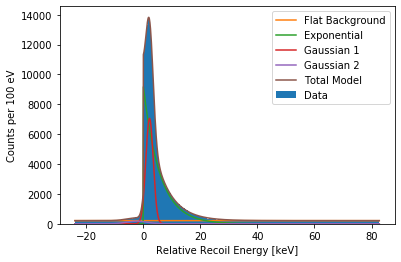

In [34]:
x_values = np.array([ np.min(data) , np.max(data)])
all_bins = np.arange(start=x_values[0],stop=x_values[1],step=bin_step)
pdf_bkgd = PDF_Background(all_bins)

bkgd_vals = PDF_Background_keV(all_bins)
expo_vals = PDF_Exponential_keV(all_bins)
gss1_vals = PDF_Gauss1_keV(all_bins)
gss2_vals = PDF_Gauss2_keV(all_bins)
pdf_vals  = PDF_total(all_bins)

plt.figure()
hist, bins, patches = plt.hist(data, bins=all_bins, label="Data")
plt.plot(all_bins, bkgd_vals*bin_step, label="Flat Background")
plt.plot(all_bins, expo_vals*bin_step, label="Exponential")
plt.plot(all_bins, gss1_vals*bin_step, label="Gaussian 1")
plt.plot(all_bins, gss2_vals*bin_step, label="Gaussian 2")
plt.plot(all_bins, pdf_vals*bin_step, label="Total Model")
plt.xlabel("Relative Recoil Energy [keV]")
plt.ylabel("Counts per 100 eV")
plt.legend(loc='upper right')

In [38]:
print("Flat Background Rate:",HIGH_E_BIN_RATE,"per 100 eV")
print("Exponential     Rate:",PDF_EXPO_AMP,"per 100 eV -- scale=",PDF_EXPO_SCALE,"keV")
print("Gaussian 1      Rate:",PDF_GSS1_AMP,"per 100 eV -- mu=",PDF_GSS1_MU,"keV, sigma=",PDF_GSS1_SIG,"keV")
print("Gaussian 2      Rate:",PDF_GSS2_AMP,"per 100 eV -- mu=",PDF_GSS2_MU,"keV, sigma=",PDF_GSS2_SIG,"keV")

rate_sum = HIGH_E_BIN_RATE + PDF_EXPO_AMP + PDF_GSS1_AMP + PDF_GSS2_AMP
print("Observed Relative Rates:", HIGH_E_BIN_RATE/rate_sum ,
                                  PDF_EXPO_AMP/rate_sum ,
                                  PDF_GSS1_AMP/rate_sum ,
                                  PDF_GSS2_AMP/rate_sum ,)

print("True Background  Rate:",ndis[0])
print("True Exponential Rate:",ndis[1],"Scale=",e1_p[1],"keV")
print("True Gaussian 1  Rate:",ndis[2],"Mean=",g1_p[1],"keV, Sigma=",g1_p[2])
print("True Gaussian 2  Rate:",ndis[3],"Mean=",g2_p[1],"keV, Sigma=",g2_p[2])

print("True Relative Rates:", ndis[0]/npts ,
                              ndis[1]/npts ,
                              ndis[2]/npts ,
                              ndis[3]/npts ,)


Flat Background Rate: 211.755 per 100 eV
Exponential     Rate: 9189.520634029726 per 100 eV -- scale= 5.7786054152533985 keV
Gaussian 1      Rate: 7057.019264917969 per 100 eV -- mu= 2.165644518082906 keV, sigma= 1.3035332724656497 keV
Gaussian 2      Rate: 179.154170656184 per 100 eV -- mu= -2.360324233400063 keV, sigma= -3.519554995090998 keV
Observed Relative Rates: 0.01272761221471566 0.5523395200541114 0.42416474036340895 0.010768127367764167
True Background  Rate: 83179
True Exponential Rate: 219251 Scale= 4.8867727877328315 keV
True Gaussian 1  Rate: 225358 Mean= 7.486735496204448 keV, Sigma= 7.839578502681963
True Gaussian 2  Rate: 472212 Mean= 2.230183264437694 keV, Sigma= 1.2647881369805314
True Relative Rates: 0.083179 0.219251 0.225358 0.472212
